In [14]:
from pandas import DataFrame, read_excel
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
#IMPORT MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.binary):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Loading data

In [15]:
#read training and test data
p4jtraining = pd.DataFrame()
addtraining = pd.DataFrame()
s4rtraining = pd.DataFrame()
p4jtest = pd.DataFrame()
addtest = pd.DataFrame()
s4rtest = pd.DataFrame()

P4J_training_list= ["./data/P4JD4J.csv"]
ADD_training_list= ["./data/AddD4J.csv"]
S4R_training_list= ["./data/S4RD4J.csv"]

RZero_testing_list= ["./data/RZeroFeatures.csv"]


In [16]:
for f in P4J_training_list:
    data = pd.read_csv(f, encoding='latin1',index_col=False)
    p4jtraining = p4jtraining.append(data, ignore_index=True)
    
for f in ADD_training_list:
    data = pd.read_csv(f, encoding='latin1',index_col=False)
    addtraining = addtraining.append(data, ignore_index=True)
    
    
for f in S4R_training_list:
    data = pd.read_csv(f, encoding='latin1',index_col=False)
    s4rtraining = s4rtraining.append(data, ignore_index=True)    
    
    
p4jtraining=p4jtraining.iloc[:,:152]
addtraining=addtraining.iloc[:,:28]
s4rtest=s4rtest.iloc[:,:28]
addtraining=addtraining.drop(columns='label')
s4rtraining=s4rtraining.drop(columns='label')
training = p4jtraining.merge(addtraining, on="id").merge(s4rtraining, on="id")  

training.shape

(10302, 204)

In [17]:
training.head(2)

,id,label,srcABSTV,srcAssignConst,srcAssignLHS,srcAssignZero,srcCALLEE,srcCallArgument,srcChanged,srcDEREF,...,similarObjectTypeWithNullGuard,typeOfFaultyStmt,fieldNotAssigned,fieldNotUsed,similarPrimitiveTypeWithNormalGuard,similarPrimitiveTypeWithNullGuard,methodThrowsException,objectUsedInAssignment,primitiveUsedInAssignment,methodCallWithNormalGuard
0,GenProg_patch_Defects4J_Chart_1_0_129,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,LocalVariable,0,0,0,0,0,0,0.0,0.0
1,GenProg_patch_Defects4J_Chart_1_0_31,1,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,...,0,LocalVariable,0,0,0,0,0,0,0.0,0.0


In [18]:
for f in RZero_testing_list:
    data = pd.read_csv(f, encoding='latin1',index_col=False)
    test = addtest.append(data, ignore_index=True)
    
test =  test.iloc[:,:204]
test.shape

(81, 204)

In [19]:
#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about validation samples
# overfittinginValidation = validation[validation['label']==1]
# correctinValidation=validation[validation['label']==0]
# print("Total validation: ", validation.shape)
# print("overfitting in train",overfittinginValidation.shape)
# print("correct in train",correctinValidation.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)

Total train:  (10302, 204)
overfitting in train (8299, 204)
correct in train (2003, 204)
Total test:  (81, 204)
overfitting in test (81, 204)
correct in test (0, 204)


In [20]:
# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]


# process category features

In [21]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
print(headers)
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)

X_train.head(2)

Index(['srcABSTV', 'srcAssignConst', 'srcAssignLHS', 'srcAssignZero',
       'srcCALLEE', 'srcCallArgument', 'srcChanged', 'srcDEREF',
       'srcFuncArgument', 'srcGlobalVariable',
       ...
       'typeOfFaultyStmt_ NewClass', 'typeOfFaultyStmt_ OperatorAssignment',
       'typeOfFaultyStmt_ Parameter', 'typeOfFaultyStmt_ Return',
       'typeOfFaultyStmt_ Switch', 'typeOfFaultyStmt_ Throw',
       'typeOfFaultyStmt_ Try', 'typeOfFaultyStmt_ TypeReference',
       'typeOfFaultyStmt_ UnaryOperator', 'typeOfFaultyStmt_ While'],
      dtype='object', length=451)


,srcABSTV,srcAssignConst,srcAssignLHS,srcAssignZero,srcCALLEE,srcCallArgument,srcChanged,srcDEREF,srcFuncArgument,srcGlobalVariable,...,typeOfFaultyStmt_ NewClass,typeOfFaultyStmt_ OperatorAssignment,typeOfFaultyStmt_ Parameter,typeOfFaultyStmt_ Return,typeOfFaultyStmt_ Switch,typeOfFaultyStmt_ Throw,typeOfFaultyStmt_ Try,typeOfFaultyStmt_ TypeReference,typeOfFaultyStmt_ UnaryOperator,typeOfFaultyStmt_ While
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
print(X_train.shape)
print(X_test.shape)

(10302, 451)
(81, 451)


# Shuffle the training and test data

In [23]:
from sklearn.utils import shuffle
X_train, Y_train = shuffle(X_train, Y_train, random_state=0)

In [24]:
X_train.shape,  Y_train.shape

((10302, 451), (10302,))

In [25]:
X_test.shape, Y_test.shape

((81, 451), (81,))

[0]	validation_0-map:1.00000
Will train until validation_0-map hasn't improved in 5 rounds.
[1]	validation_0-map:1.00000
[2]	validation_0-map:1.00000
[3]	validation_0-map:1.00000
[4]	validation_0-map:1.00000
[5]	validation_0-map:1.00000
Stopping. Best iteration:
[0]	validation_0-map:1.00000

f1 score: 0.8827586206896552
acc score: 0.7901234567901234
precision score: 1.0
recall score: 0.7901234567901234


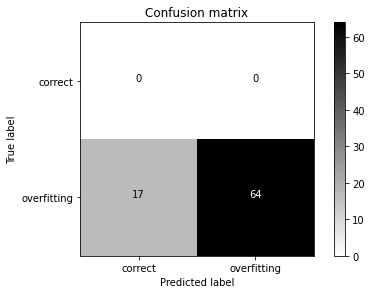

In [26]:
import xgboost as xgb
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

model = xgb.XGBClassifier(random_state=42, max_depth=6)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=5, eval_metric="map", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)

# Plot non-normalized confusion matrix
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()  


In [27]:
d={'patch':test_file_name,'label':Y_pred}
fn3 = pd.DataFrame(d)
fn3.to_csv('./data/RZeroPatchLabel.csv')
print(fn3.head(30))

                      patch  label
0          taljmars-patch_1      0
1    RBMHTechnology-patch_1      1
2   clebertsuconic-patch_27      1
3        featurecat-patch_8      1
4    java-group-blr-patch_1      1
5   clebertsuconic-patch_31      1
6   clebertsuconic-patch_46      1
7   clebertsuconic-patch_11      1
8   clebertsuconic-patch_50      0
9        featurecat-patch_4      1
10           Luki42-patch_1      1
11       featurecat-patch_5      1
12  clebertsuconic-patch_51      0
13  clebertsuconic-patch_10      1
14          vert-x3-patch_2      1
15  clebertsuconic-patch_47      0
16       featurecat-patch_9      1
17  clebertsuconic-patch_26      1
18   clebertsuconic-patch_1      1
19  clebertsuconic-patch_40      0
20  clebertsuconic-patch_17      1
21  clebertsuconic-patch_56      1
22       featurecat-patch_2      1
23   clebertsuconic-patch_6      1
24  clebertsuconic-patch_37      0
25  clebertsuconic-patch_20      1
26   clebertsuconic-patch_7      1
27   RBMHTechnology-